_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student name: FILL IN YOUR NAMES HERE

# Coding Lab 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from scipy import fft
from scipy.io import loadmat
import math
# import oopsi from Vogelstein et al.
from oopsi import fast


sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [64]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv(r'data\nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv(r'data\nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv(r'data\nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv(r'data\nda_ex_4_gcamp2_spikes.csv', header=0)  


In [60]:
ogb_calcium

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595
...,...,...,...,...,...,...,...,...,...,...,...
71981,0.538533,0.399124,NaN,0.821013,-0.170785,1.158751,0.682918,0.148761,0.652645,NaN,0.783607
71982,0.712870,0.418369,NaN,0.838734,-0.260950,1.180239,0.313320,0.151934,0.660206,NaN,0.786171
71983,0.670323,0.356299,NaN,0.842801,-0.264011,1.228860,0.215326,0.221346,0.631483,NaN,0.687742
71984,0.355962,0.335461,NaN,0.759840,-0.186234,1.177698,0.688985,0.307233,0.545631,NaN,0.590033


In [66]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [67]:
ogb_calcium = pd.DataFrame(signal.decimate(ogb_calcium, 4, axis=0))
ogb_spikes = pd.DataFrame(np.clip(signal.decimate(ogb_spikes, 4, axis=0),0, None))

gcamp_calcium = pd.DataFrame(signal.decimate(gcamp_calcium, 4, axis=0))
gcamp_spikes = pd.DataFrame(np.clip(signal.decimate(gcamp_spikes, 4, axis=0), 0, None))

In [98]:
ogb_calcium



,0,1,2,3,4,5,6,7,8,9,10
0,-0.237497,0.673110,NaN,NaN,-0.018070,0.776854,2.355490,NaN,0.233488,NaN,0.589933
1,0.129705,1.022041,NaN,NaN,0.360690,1.369455,1.968432,NaN,0.539878,NaN,0.746836
2,0.244065,0.865613,NaN,NaN,0.110724,1.473531,1.908705,NaN,0.402654,NaN,0.547252
3,0.241235,0.783545,NaN,NaN,0.014047,0.914192,1.520128,NaN,0.533728,NaN,0.664842
4,0.387033,0.537671,NaN,NaN,0.160865,0.651957,1.077111,NaN,0.802082,NaN,0.782269
...,...,...,...,...,...,...,...,...,...,...,...
1120,0.822519,0.663161,NaN,NaN,0.447071,0.580654,0.811590,NaN,0.645926,NaN,0.340748
1121,0.801158,0.565213,NaN,NaN,0.587365,0.689862,0.567941,NaN,0.390919,NaN,0.410175
1122,0.373656,0.589957,NaN,NaN,0.408102,0.572406,0.703654,NaN,0.719036,NaN,0.729101
1123,0.477328,0.376493,NaN,NaN,0.208806,0.796459,0.591300,NaN,0.807271,NaN,0.662848


Text(0.5, 1.0, 'GCamp6 recording for cell 6')

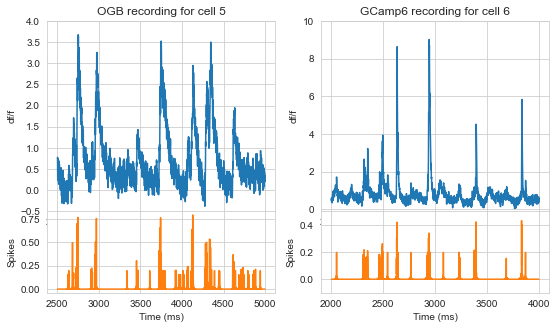

In [70]:
fig = plt.figure(figsize=(9,5))
 
gs = fig.add_gridspec(2,2, height_ratios=[.7,.3] ,hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax1.plot(ogb_calcium[4][2500:5000])
ax2.plot(ogb_spikes[4][2500:5000], color="#ff7f0e")
ax3.plot(gcamp_calcium[5][2000:4000])
#ax1.set_xlim(10000,20000)
#ax3.set_xlim(8000,17000)
ax1.set_ylim(-.5,4)
ax4.plot(gcamp_spikes[5][2000:4000], color="#ff7f0e")
ax1.set_ylabel("df/f")
ax2.set_ylabel("Spikes")
ax3.set_ylabel("df/f")
ax4.set_ylabel("Spikes")
ax4.set_ylim(-.1, .5)
ax3.set_ylim(-.1, 10)
ax2.set_xlabel("Time (ms)")
ax4.set_xlabel("Time (ms)")
ax1.set_title("OGB recording for cell 5")
ax3.set_title("GCamp6 recording for cell 6")


In [ ]:
ogb_spikes.head()

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

In [ ]:
fig = plt.figure(figsize=(9, 5))

# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------

plt.show()

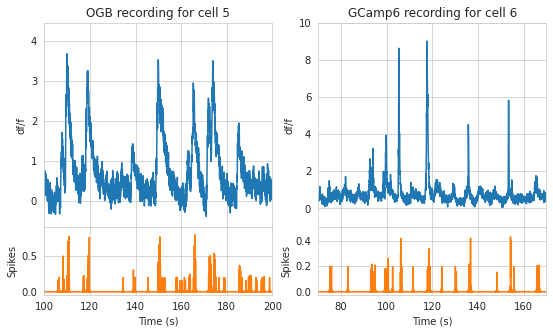

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


Text(0.5, 1.0, '$k_{exp}(t,\\tau)$')

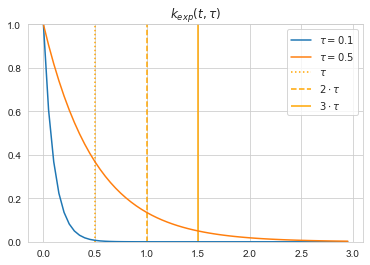

In [61]:
fig, ax = plt.subplots(1,1)
tau_ogb = .5
tau_gcamp = .1
time = np.arange(start=0,stop=3, step=.05)
kernel5 = math.e**(-time/tau_ogb)
kernel1 = math.e**(-time/tau_gcamp)
ax.plot(time,kernel1, label = r"$\tau = 0.1$")
ax.plot(time,kernel5, label = r"$\tau = 0.5$")


ax.vlines(tau_ogb, 0, 1.1, color="orange", linestyle=":",  label=r"$\tau$ ")
ax.vlines(tau_ogb*2, 0, 1.1, color="orange", linestyle="--", label=r"$2\cdot \tau$ ")
ax.vlines(tau_ogb*3, 0, 1.1, color="orange", label=r"$3\cdot \tau$ ")
ax.legend()
ax.set_ylim(0,1.)
ax.set_title(r"$k_{exp}(t,\tau)$")
#plt.plot(1/kernel)
#plt.plot(1/scipy.fft.fft(kernel))

C:\Users\marid\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


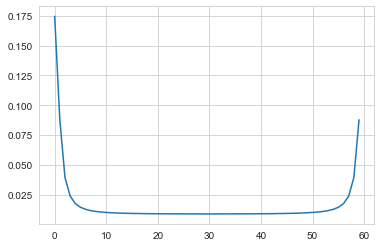

In [58]:
plt.plot(fft.ifft(kernel5))

In [ ]:
def deconv_ca(ca, tau, dt):
    '''Compute the BIC for a fitted Mixture of Gaussian model
    
    Parameters
    ----------
    
    ca: np.array, (n_points,)
        Calcium trace
    
    tau: float
        decay constant of conv kernel
    
    dt: float
        sampling interval.
    
    Return
    ------
    
    sp_hat: np.array    
    '''
    
    # insert your code here
    
    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    return sp_hat

In [26]:
range1 = np.arange(10)
range2 = np.arange(10)

first_mult_then_sum = np.sum(range1*range2)
print(first_mult_then_sum)
first_sum_then_mult = np.sum(range1)*np.sum(range2)
print(first_sum_then_mult)

285
2025


In [ ]:
plt.figure(figsize=(6,5))

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

sns.despine()

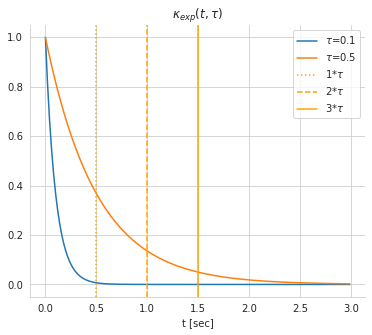

In [72]:
ogb_calcium[5]

0        0.809080
1        1.169652
2        1.236355
3        1.061192
4        0.870407
           ...   
17992    1.217638
17993    1.205213
17994    1.183842
17995    1.268332
17996    1.098661
Name: 5, Length: 17997, dtype: float64

(0.0, 25.0)

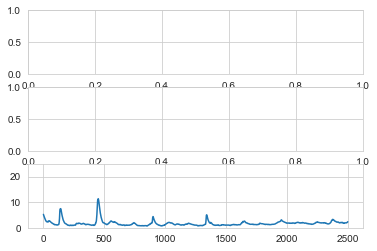

In [82]:
plt.plot(np.convolve(ogb_calcium[5], kernel5))

(0.0, 25.0)

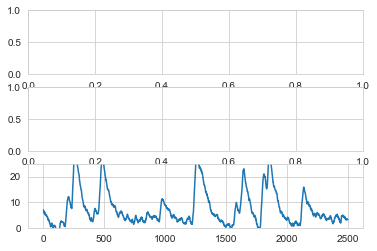

In [84]:
plt.subplots(3,1)
plt.plot((np.convolve(ogb_calcium[4], kernel5)*0.)[2500:5000])
plt.ylim(0,25)

In [ ]:
fig = plt.figure(figsize=(6,4))

# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

plt.show()

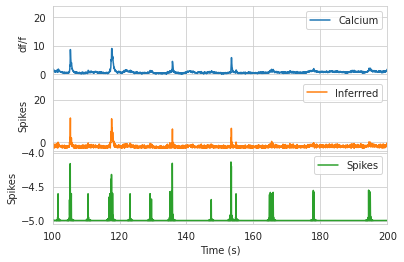

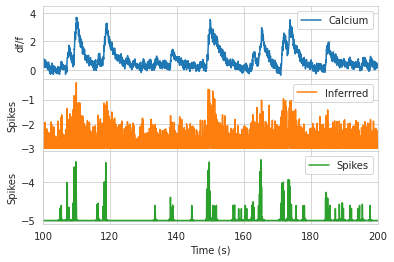

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [ ]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# -------------------------------------------------------------- 

In [ ]:
fig = plt.figure(figsize=(6,4))

# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

plt.show()

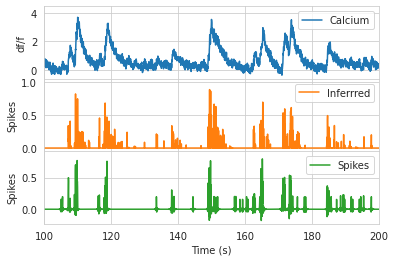

In [ ]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

In [ ]:
fig = plt.figure(figsize=(6,4))

# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

plt.show()

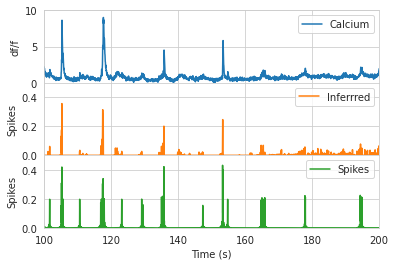

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [ ]:
# insert your code here

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
# insert your code here

Combine both dataframes and plot

In [ ]:
plt.figure(figsize=(6, 6))

# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# ---------------------------------------------------------------------------

plt.show()

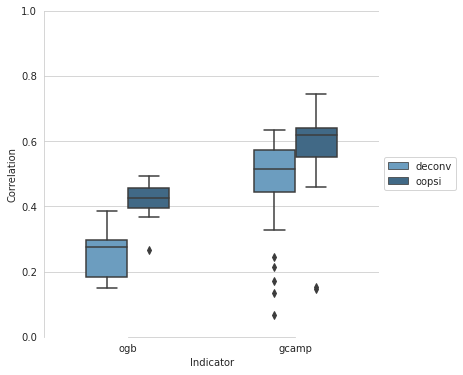